# Downloading DSM and DTM files

### First, let's select our area of study


In [2]:
## hold for example area selecting and visualization
## get other datasets from the spatial db as well, like lakes, roads, streams, etc...

### Now, using gdal_translate via bash command-line to get hold of the DTM data at the area of study, resampled to 5 m. We also converted the data to metres, and float.

In [ ]:
%%bash
# Input arguments
INPUT_RASTER=/vsicurl/https://fdri-o.s3-ext.jc.rl.ac.uk/lidar/joined/merged_engwal_dtm.tif
INPUT_SHP=data/raw/54080.shp
OUTPUT_RASTER=data/raw/dtm.tif
PIXEL_SIZE=5

# Temporary file for the buffered extent
TEMP_EXTENT_FILE="extent.txt"

# Extract the bounding box of the shapefile
EXTENT=$(ogrinfo -al -so "$INPUT_SHP" | grep "Extent" | sed 's/Extent: //; s/[(,)]//g')

# Read coordinates from extent output
read -r MIN_X MIN_Y sign MAX_X MAX_Y <<< "$EXTENT"

# echo "Extent: MIN_X=$MIN_X, MIN_Y=$MIN_Y, MAX_X=$MAX_X, NEW_MAX_Y=$MAX_Y"

# Apply a buffer of 1 km (1000 meters)
BUFFER=1000
NEW_MIN_X=$(awk -v minx="$MIN_X" -v buf="$BUFFER" 'BEGIN {print minx - buf}')
NEW_MIN_Y=$(awk -v miny="$MIN_Y" -v buf="$BUFFER" 'BEGIN {print miny - buf}')
NEW_MAX_X=$(awk -v maxx="$MAX_X" -v buf="$BUFFER" 'BEGIN {print maxx + buf}')
NEW_MAX_Y=$(awk -v maxy="$MAX_Y" -v buf="$BUFFER" 'BEGIN {print maxy + buf}')

# echo "Buffered Extent: NEW_MIN_X=$NEW_MIN_X, NEW_MIN_Y=$NEW_MIN_Y, NEW_MAX_X=$NEW_MAX_X, NEW_MAX_Y=$NEW_MAX_Y"


# Run gdal_translate using the buffered extent
gdal_translate -projwin "$NEW_MIN_X" "$NEW_MAX_Y" "$NEW_MAX_X" "$NEW_MIN_Y" \
    -tr "$PIXEL_SIZE" "$PIXEL_SIZE" -ot Float32 -scale 0 1000 0 1 \
    -of GTiff "$INPUT_RASTER" "$OUTPUT_RASTER"

echo "Clipped raster saved as $OUTPUT_RASTER"

Input file size is 576000, 661000
0...10...20...30...40...50...60...70...80...90...100 - done.
Clipped raster saved as data/raw/54080_dtm.tif


In [1]:
import subprocess
import sys

def get_raster_at_roi(input_raster, input_shp, output_raster, pixel_size=5, buffer=1000):
    """
    Extracts a raster for a region of interest (ROI) defined by a shapefile.
    The function retrieves a raster from an online source (e.g., AWS S3, URL), 
    clips it to the shapefile extent with an optional buffer, and saves it locally.

    Parameters:
    - input_raster (str): URL or S3 path to the input raster.
    - input_shp (str): Path to the shapefile defining the region of interest (ROI).
    - output_raster (str): Path to save the clipped raster.
    - pixel_size (int, optional): Output pixel size in meters (default = 5m).
    - buffer (int, optional): Buffer distance (meters) to extend the clipping extent (default = 1000m).

    Returns:
    - Prints GDAL command output **in real-time** and saves the clipped raster.
    """

    # Extract extent from shapefile
    ogrinfo_cmd = f"ogrinfo -al -so {input_shp} | grep 'Extent' | sed 's/Extent: //; s/[(,)]//g'"
    extent_output = subprocess.run(ogrinfo_cmd, shell=True, capture_output=True, text=True)

    if extent_output.returncode != 0:
        print(f"❌ Error retrieving shapefile extent: {extent_output.stderr}")
        return
    
    # Read extracted extent
    extent = extent_output.stdout.strip()
    if not extent:
        print("❌ No extent data retrieved. Check if the shapefile exists and is valid.")
        return

    print(f"✅ Extracted extent: {extent}")

    try:
        min_x, min_y, _, max_x, max_y = extent.split()
        min_x, min_y, max_x, max_y = map(float, [min_x, min_y, max_x, max_y])
    except ValueError:
        print("❌ Error parsing extent coordinates.")
        return

    # Compute buffered extent
    new_min_x = min_x - buffer
    new_min_y = min_y - buffer
    new_max_x = max_x + buffer
    new_max_y = max_y + buffer

    print(f"📏 Buffered Extent: ({new_min_x}, {new_min_y}, {new_max_x}, {new_max_y})")

    # GDAL Translate command to clip the raster
    gdal_cmd = f"""
    gdal_translate -projwin {new_min_x} {new_max_y} {new_max_x} {new_min_y} \
        -tr {pixel_size} {pixel_size} -ot Float32 -scale 0 1000 0 1 \
        -of GTiff {input_raster} {output_raster}
    """

    print("🚀 Running GDAL Translate...")
    print(f"🖥️ GDAL Command:\n{gdal_cmd}")

    # Run GDAL command and stream output in real-time
    process = subprocess.Popen(
        gdal_cmd,
        shell=True,
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        bufsize=1,  # Line buffering
        universal_newlines=True  # Ensures proper streaming of text
    )

    # Stream real-time output **without buffering**
    for line in iter(process.stdout.readline, ""):
        sys.stdout.write(line)
        sys.stdout.flush()  # Ensure immediate output

    process.wait()  # Ensure process completes

    if process.returncode == 0:
        print(f"\n✅ Clipped raster successfully saved as: {output_raster}")
    else:
        print(f"\n❌ Error during clipping. Exit code: {process.returncode}")


In [ ]:
input_raster = "/vsicurl/https://fdri-o.s3-ext.jc.rl.ac.uk/lidar/joined/merged_engwal_dtm.tif"
input_shp = "data/raw/nrfa_catchments/54080.shp"
output_raster = "data/processed/dtm.tif"

# Run the function
get_raster_at_roi(input_raster, input_shp, output_raster)

✅ Extracted extent: <map object at 0x7fe7dcf4e2f0>
❌ Error parsing extent coordinates.


In [ ]:
input_raster = "/vsicurl/https://fdri-o.s3-ext.jc.rl.ac.uk/lidar/joined/merged_engwal_dsm.tif"
input_shp = "data/raw/nrfa_catchments/54080.shp"
output_raster = "data/processed/dsm.tif"

# Run the function
get_raster_at_roi(input_raster, input_shp, output_raster)

✅ Extracted extent: 281525.000100 275075.000100 - 302575.000100 295575.000100
📏 Buffered Extent: (280525.0001, 274075.0001, 303575.0001, 296575.0001)
🚀 Running GDAL Translate...
🖥️ GDAL Command:

    gdal_translate -projwin 280525.0001 296575.0001 303575.0001 274075.0001         -tr 5 5 -ot Float32 -scale 0 1000 0 1         -of GTiff /vsicurl/https://fdri-o.s3-ext.jc.rl.ac.uk/lidar/joined/merged_engwal_dsm.tif data/processed/dsm.tif
    


## Now let's visualize our dataset

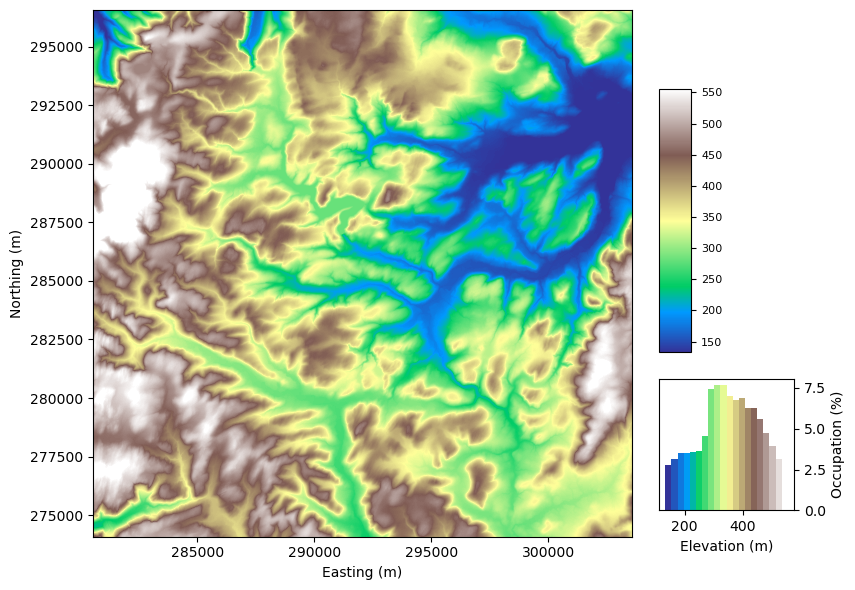

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import rasterio

# Load raster with rasterio to get georeferencing
raster_path = "data/raw/dtm.tif"
with rasterio.open(raster_path) as src:
    raster = src.read(1)  # Read the first band
    transform = src.transform  # Get the georeferencing transform
    bounds = src.bounds  # Get raster bounding box

# Compute Color Normalization
datamin = np.percentile(valid_data, 2)
datamax = np.percentile(valid_data, 98)
norm = colors.Normalize(vmin=datamin, vmax=datamax)
cmap = "terrain"

# Compute Real-World Extent
extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]  # (minX, maxX, minY, maxY)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

# Display the raster with real-world extent
img = ax.imshow(raster, cmap=cmap, norm=norm, extent=extent, origin="upper")

ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")

# Create a colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cax = ax.inset_axes([1.05, 0.35, 0.06, 0.5])  # Position the colorbar inset
cbar = plt.colorbar(sm, cax=cax)
cbar.ax.tick_params(labelsize=8)
cax.yaxis.set_ticks_position('right')
cax.yaxis.set_label_position('right')

# Histogram inset
hax = ax.inset_axes([1.05, 0.05, 0.25, 0.25])
colormap = plt.colormaps.get_cmap(cmap)

# Filter raster values for histogram
data = valid_data[(valid_data > datamin) & (valid_data < datamax)]

# Plot % histogram
n = len(data)
_, bins, patches = hax.hist(data, bins=20, edgecolor='none', weights=np.ones(n)/n*100)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Normalize bin centers to [0, 1]
col = (bin_centers - min(bin_centers)) / (max(bin_centers) - min(bin_centers))

for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', colormap(c))

hax.set_xlabel('Elevation (m)')
hax.set_ylabel('Occupation (%)')
hax.yaxis.set_ticks_position('right')
hax.yaxis.set_label_position('right')

plt.tight_layout()
plt.show()

## For interactive visualization

## 3D visualization

In [ ]:
import numpy as np
import rasterio
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib import colormaps
from rasterio.enums import Resampling

# **Step 1: Load the Raster**
raster_path = "data/raw/dtm.tif"
with rasterio.open(raster_path) as src:
    # Read the raster and resample for performance
    data = src.read(
        1, resampling=Resampling.bilinear
    )  # Read first band (elevation)
    transform = src.transform  # Get the spatial transform

# **Step 2: Generate X, Y Coordinates**
rows, cols = data.shape
x_coords = np.linspace(transform.c, transform.c + transform.a * cols, cols)
y_coords = np.linspace(transform.f, transform.f + transform.e * rows, rows)
X, Y = np.meshgrid(x_coords, y_coords)

# **Step 3: Convert Matplotlib 'terrain' Colormap to Plotly Format**
cmap = colormaps["terrain"]
terrain_colorscale = [[i / 255, f"rgb{tuple(np.array(cmap(i)[:3]) * 255)}"] for i in range(256)]

# **Step 4: Create Interactive 3D Plot with Plotly**
fig = go.Figure()

fig.add_trace(
    go.Surface(z=data, x=X, y=Y, colorscale=terrain_colorscale)
)

# **Step 5: Customize Plot Appearance**
fig.update_layout(
    title="Interactive 3D Terrain Model",
    scene=dict(
        xaxis_title="Longitude",
        yaxis_title="Latitude",
        zaxis_title="Elevation (m)",
    ),
    margin=dict(l=0, r=0, t=40, b=0),
)

# **Step 6: Display Interactive 3D Plot**
fig.show()
